In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as matplot

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, min, max, mean, to_date, year, month

## Load Dataframe from previous Notebook from Pickle File

In [45]:
tem_train = pd.read_pickle('tem_train.pkl')
tem_test = pd.read_pickle('tem_test.pkl')
filtered_tem_logscale = pd.read_pickle('filtered_tem_logscale.pkl')

# ML Algorithm Training

## ARIMA Algorithm Training

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1812.792, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1207.149, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1193.232, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1228.580, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=921.351, Time=0.20 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1244.211, Time=0.36 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-1190.644, Time=0.76 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1234.289, Time=0.90 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1240.938, Time=0.50 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1223.761, Time=0.40 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-1199.067, Time=0.93 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1244.832, Time=0.63 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept 

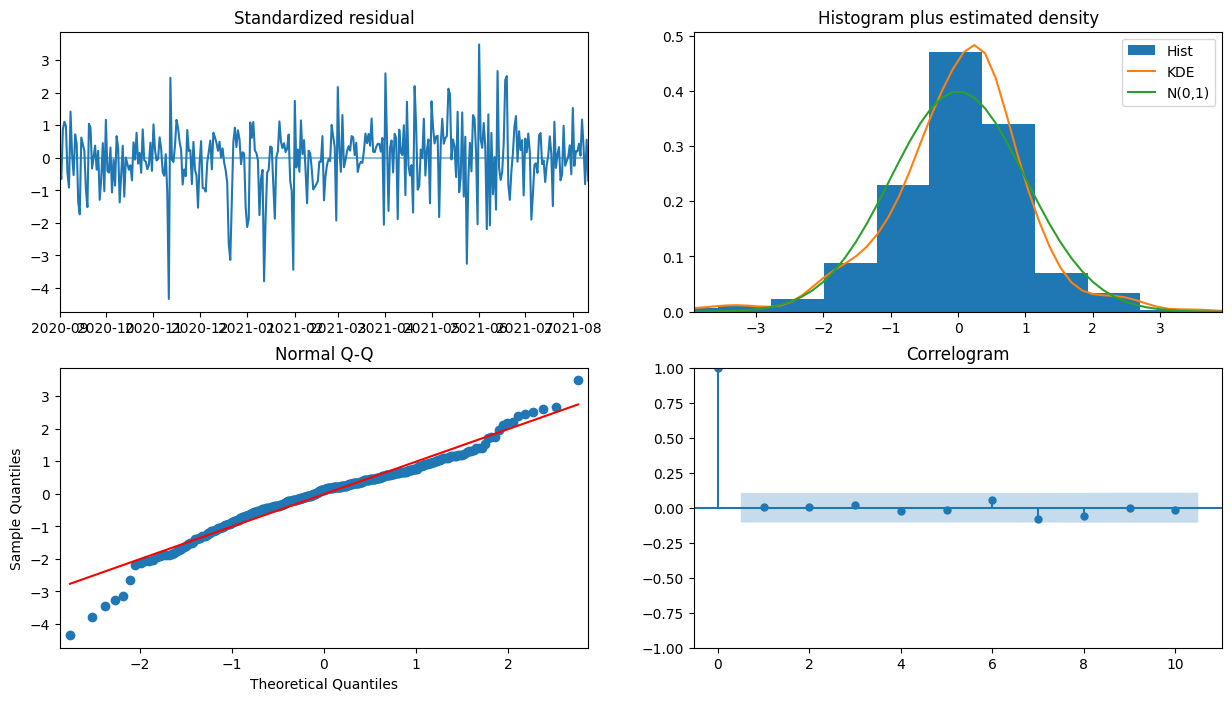

In [46]:
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(tem_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [47]:
# ARIMA LİBRARY
warnings.filterwarnings("ignore")
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime

# fit model
model = ARIMA(tem_train, order=(1,0,3)) # (ARIMA) = (1,0,1)
model_fit = model.fit()


# fit model
#(1, 1, 2)
#model = ARIMA(tem_train, order=(5,1,0))
#model = ARIMA(tem_train, order=(1, 0, 0))
#model = ARIMA(tem_train, order=(2,1,2))
#model_fit = model.fit()


# summary of fit model
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Temperature_Celsius   No. Observations:                  345
Model:                  ARIMA(1, 0, 3)   Log Likelihood                 632.000
Date:                 Sun, 15 Dec 2024   AIC                          -1252.000
Time:                         23:13:28   BIC                          -1228.938
Sample:                     09-01-2020   HQIC                         -1242.815
                          - 08-11-2021                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3400      0.022    151.561      0.000       3.297       3.383
ar.L1          0.9687      0.018     52.612      0.000       0.933       1.005
ma.L1         -0.2722      0.050     -5.392 

## Check the model summary

In [48]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Temperature_Celsius   No. Observations:                  345
Model:                  ARIMA(1, 0, 3)   Log Likelihood                 632.000
Date:                 Sun, 15 Dec 2024   AIC                          -1252.000
Time:                         23:13:28   BIC                          -1228.938
Sample:                     09-01-2020   HQIC                         -1242.815
                          - 08-11-2021                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3400      0.022    151.561      0.000       3.297       3.383
ar.L1          0.9687      0.018     52.612      0.000       0.933       1.005
ma.L1         -0.2722      0.050     -5.392      0.000      -0.371      -0.173
ma.L2         -0.2656      0.065     -4.086      0.000      -0.393      -0.138
ma.L3         -0.1648      0.060     -2.762      0.006      -0.282      -0.048
sigma2         0.0015   8.56e-05     17.471      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                90.41
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -0.61
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARIMA Algorithm Evaluation

## Training Set

In [54]:
# predict
start_index = datetime(2020, 9, 1)
end_index = datetime(2021, 8, 30)
forecast_prediction = model_fit.predict(start=start_index, end=end_index)

## Visualization the result

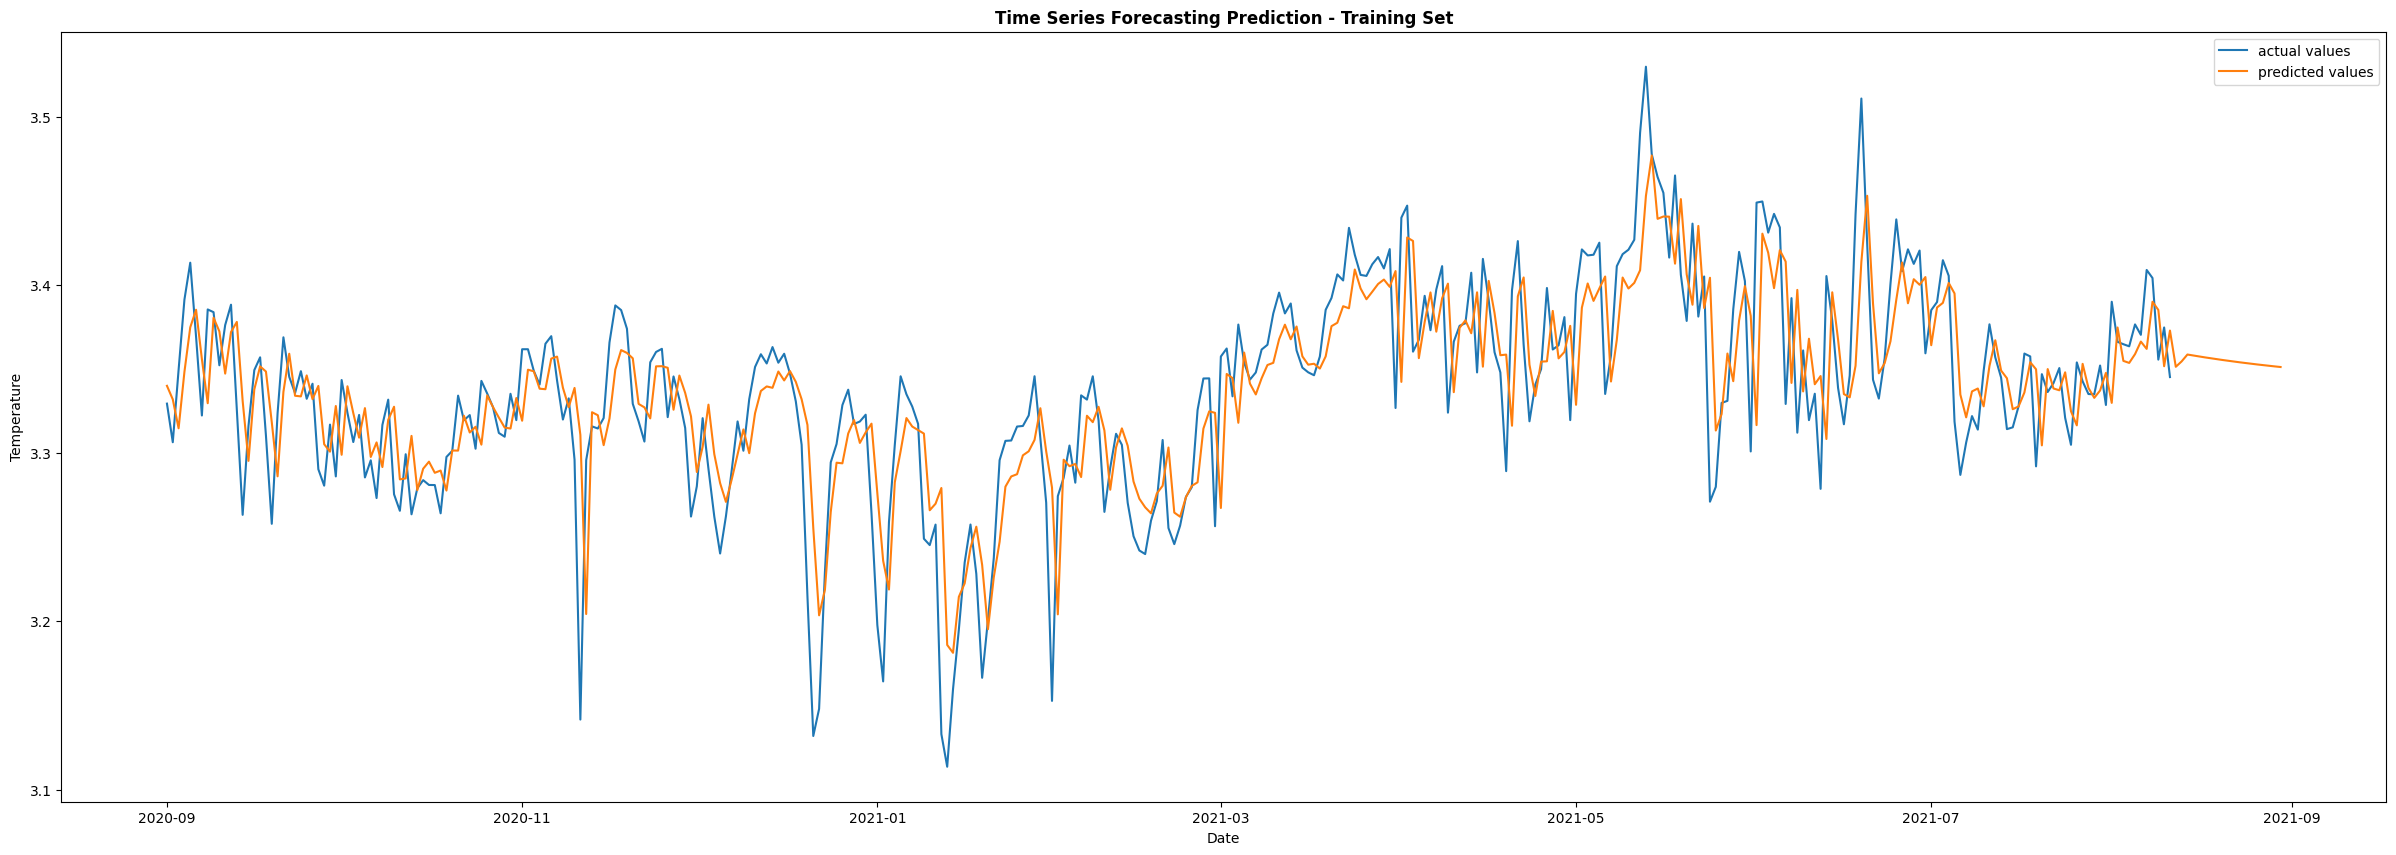

In [55]:
plt.figure(figsize=(30,10))

plt.plot(tem_train.index, tem_train.Temperature_Celsius, label = "actual values")
plt.plot(forecast_prediction ,label = "predicted values")

plt.title("Time Series Forecasting Prediction - Training Set", fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate Forecast
mae = mean_absolute_error(tem_test, forecast)
rmse = np.sqrt(mean_squared_error(tem_test, forecast))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")


Mean Absolute Error (MAE): 0.0381
Root Mean Square Error (RMSE): 0.0506


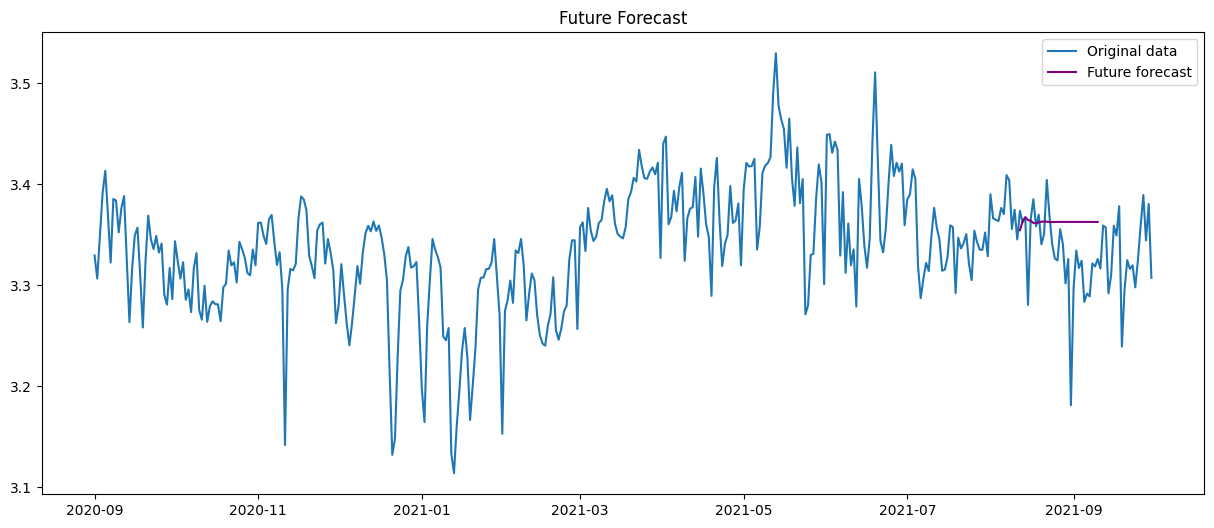

In [34]:
# Forecast next 30 steps
future_forecast = model_fit.forecast(steps=30)

# Plot the future forecast
plt.figure(figsize=(15, 6))
plt.plot(filtered_tem_logscale, label='Original data')
plt.plot(future_forecast, label='Future forecast', color='purple')
plt.title('Future Forecast')
plt.legend()
plt.show()